# Zeisel GRN Inference and Analysis

## 0. Import dependencies

In [1]:
import os
import sys
sys.path.append('../../')

from arboreto.core import *
from arboreto.utils import *

import matplotlib.pyplot as plt

## 1. Load the data (outside the scope of the arboreto API)

In [2]:
zeisel_ex_path = '/media/tmo/data/work/datasets/zeisel/expression_sara_filtered.txt'
zeisel_tf_path = '/media/tmo/data/work/datasets/TF/mm9_TFs.txt'

In [3]:
def clean_transpose(df, numeric_type=np.float32):
    t = df.T
    new_header = t.iloc[0]
    t = t[1:]
    t.columns = new_header
    return t.astype(numeric_type)

In [4]:
zeisel_df = pd.read_csv(zeisel_ex_path, sep='\t')

In [5]:
zeisel_df.shape

(13063, 3006)

In [6]:
zeisel_df.head()

,Unnamed: 0,1772071015_C02,1772071017_G12,1772071017_A05,1772071014_B06,1772067065_H06,1772071017_E02,1772067065_B07,1772067060_B09,1772071014_E04,...,1772066110_D12,1772071017_A07,1772063071_G10,1772058148_C03,1772063061_D09,1772067059_B04,1772066097_D04,1772063068_D01,1772066098_A12,1772058148_F03
0,Tspan12,0,0,0,3,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Tshz1,3,1,0,2,2,2,2,1,0,...,0,0,0,0,0,0,0,0,0,1
2,Fnbp1l,3,1,6,4,1,2,1,0,5,...,0,0,0,0,0,0,0,0,0,0
3,Adamts15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cldn12,1,1,1,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [7]:
zeisel_df_T = clean_transpose(zeisel_df)

In [8]:
zeisel_gene_names = list(zeisel_df_T.columns)

In [9]:
zeisel_ex_matrix = zeisel_df_T.as_matrix()

In [10]:
zeisel_tf_names = load_tf_names(zeisel_tf_path)

## 2. Initialize Dask client

In [11]:
from dask.distributed import Client, LocalCluster

In [12]:
client = Client(LocalCluster(memory_limit=8e9))

In [13]:
client

Client Scheduler: tcp://127.0.0.1:40011 Dashboard: http://127.0.0.1:8787,Cluster Workers: 88 Cores: 88 Memory: 704.00 GB


If you work remotely, use port forwarding to view the dashboard:

```bash
$ ssh -L 8000:localhost:8787 nostromo
```

In [ ]:
client.shutdown()

## 3. Compute GRN inference graph

In [15]:
SGBM_sqrt_KWARGS = {
    'learning_rate': 0.01,
    'max_features': 'sqrt',
    'n_estimators': 5000,
    'subsample': 0.9}

#### Create the dask computation graphs

In [16]:
%%time
network_graph, meta_graph = create_graph(zeisel_ex_matrix,
                                         zeisel_gene_names,
                                         zeisel_tf_names,
                                         "GBM",
                                         SGBM_sqrt_KWARGS,
                                         target_genes='all',
                                         early_stop_window_length=25,
                                         include_meta=True)

CPU times: user 7.04 s, sys: 624 ms, total: 7.67 s
Wall time: 7.08 s


#### Persist the distributed DataFrames

* returns futures, i.e. not yet reified references to objects

In [17]:
%%time
a, b = client.persist([network_graph, meta_graph])

CPU times: user 11.6 s, sys: 336 ms, total: 12 s
Wall time: 11.9 s


#### Compute results

In [18]:
%%time
network_df = a.compute(sync=True)

CPU times: user 4min 32s, sys: 2min 34s, total: 7min 6s
Wall time: 8min 7s


In [19]:
%%time
meta_df = b.compute(sync=True)

CPU times: user 15.2 s, sys: 1.49 s, total: 16.7 s
Wall time: 16 s


## 4. Save full and top_100k networks to file

In [20]:
len(network_df)

6618700

In [21]:
len(meta_df)

13063

In [22]:
network_df.sort_values(by='importance', ascending=0).to_csv('zeisel_sgbm_sqrt_all.txt',  index=False, sep='\t')

In [23]:
top_100k = network_df.nlargest(100000, columns=['importance'])

In [24]:
top_100k.to_csv('zeisel_sgbm_sqrt_100k.txt', index=False, sep='\t')

In [25]:
merged_df = top_100k.merge(meta_df, on='target')

In [26]:
merged_df.head()

,TF,target,importance,n_estimators
0,Dab2,Mrc1,101.790505,964
1,Maf,Mrc1,48.105636,964
2,Runx1,Mrc1,40.812373,964
3,Klf6,Mrc1,22.415216,964
4,Gabpb2,Mrc1,20.842637,964


In [27]:
merged_df['imp2'] = merged_df['importance'] / merged_df['n_estimators']

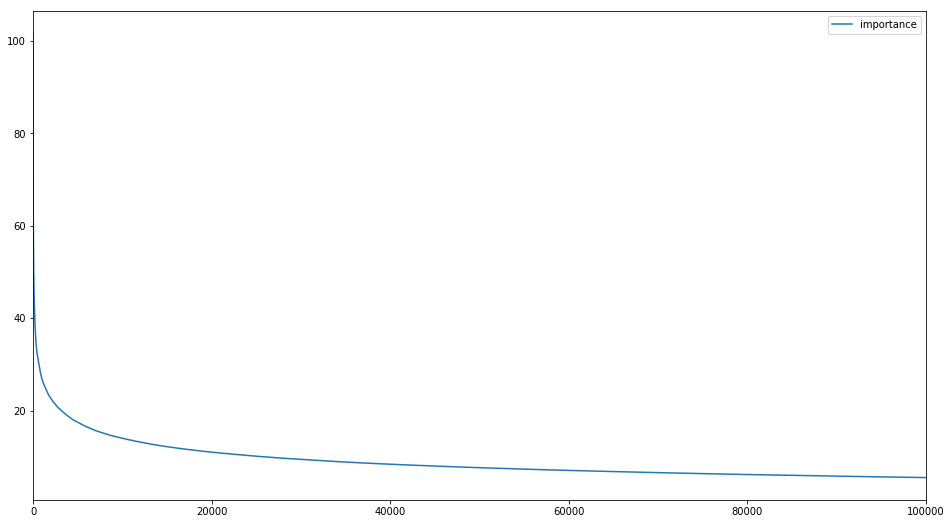

In [28]:
top_100k.plot(use_index=0, figsize=(16,9))
plt.show()

### Distribution of nr of boosting rounds per regression

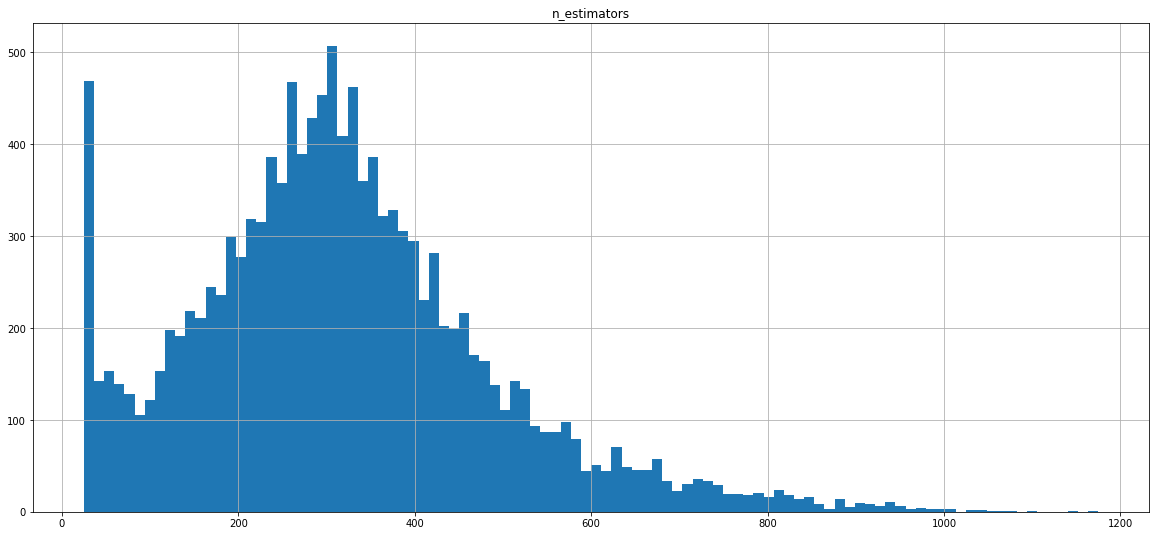

In [29]:
meta_df.hist(bins=100, figsize=(20, 9), log=0)
plt.show()

### Plot the maximum variable importance (sklearn default) vs. nr of boosting rounds

* **!= the formula in Arboreto**
* Using the sklearn default variable importances which normalizes regressions by dividing by nr of trees in the ensemble.
* Effect is that regressions with few trees also deliver high feature importances (aka network links), this is undesirable.
* In Arboreto, we omit this normalization step to make use of the nr of trees as a heuristic indicator of how much *signal* there is in a regression.

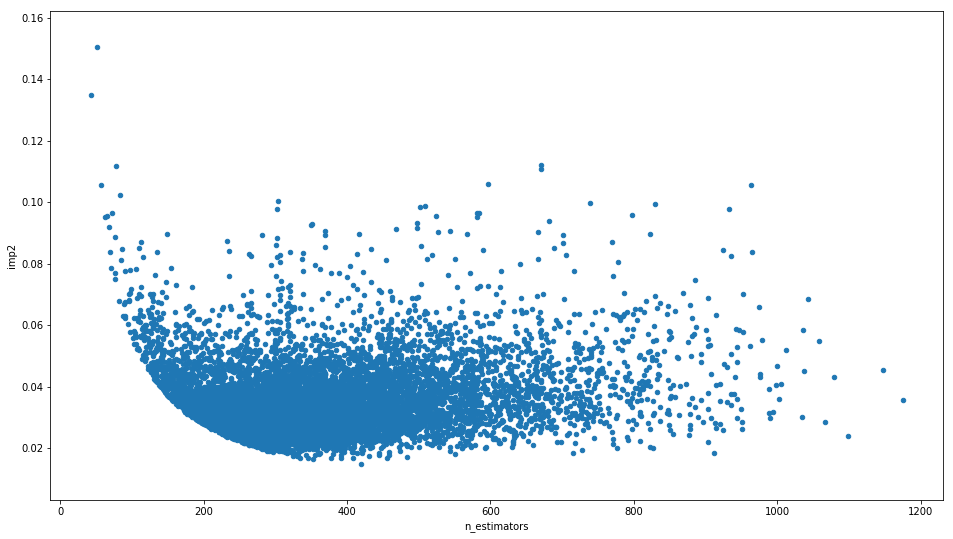

In [30]:
max_imp2_by_rounds =\
meta_df.merge(merged_df.groupby(['target'])['imp2'].nlargest(1).reset_index(), 
              how='left', 
              on=['target'])

max_imp2_by_rounds.plot.scatter(x='n_estimators', y='imp2', figsize=(16, 9))
plt.show()

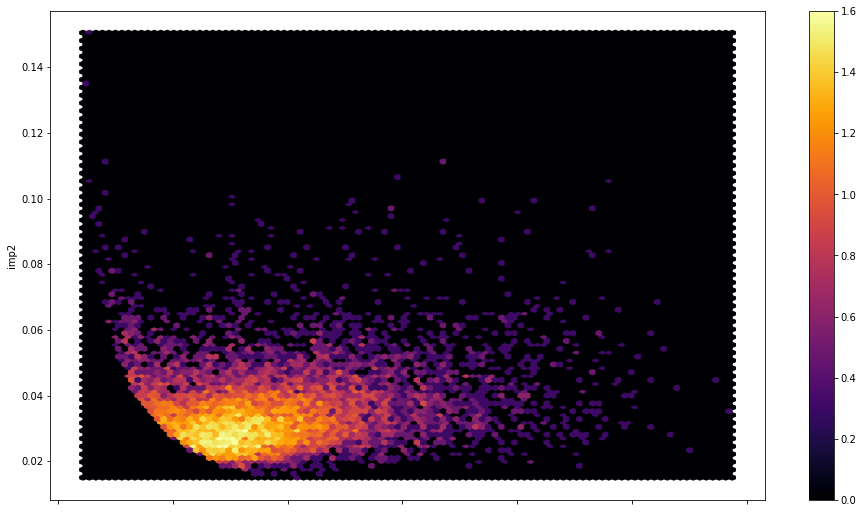

In [31]:
max_imp2_by_rounds.plot.hexbin(x='n_estimators', 
                               y='imp2', 
                               bins='log', 
                               cmap='inferno',
                               figsize=(16, 9))
plt.show()

### Plotting corrected feature importance (Arboreto SGBM default) vs. nr of boosting rounds

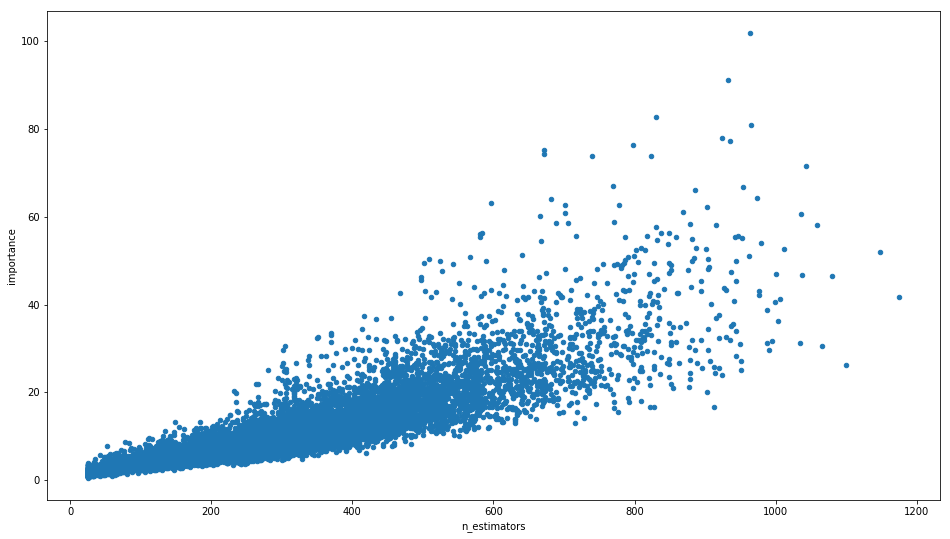

In [32]:
max_imp_by_rounds =\
meta_df.merge(network_df.groupby(['target'])['importance'].nlargest(1).reset_index(), 
              how='left', 
              on=['target'])

max_imp_by_rounds.plot.scatter(x='n_estimators', y='importance', figsize=(16, 9))
plt.show()

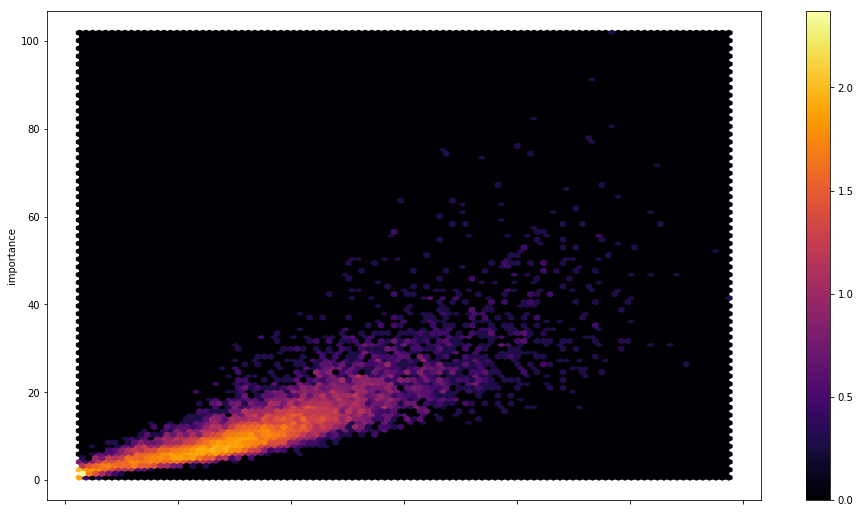

In [33]:
max_imp_by_rounds.plot.hexbin(x='n_estimators', 
                              bins='log',
                              cmap='inferno',
                              y='importance',
                              figsize=(16, 9))
plt.show()

# Links in common with GENIE3

In [34]:
z_genie3 = pd.read_csv('/media/tmo/data/work/datasets/benchmarks/genie3/zeisel/zeisel.filtered.genie3.txt', header=None, sep='\t')
z_genie3.columns=['TF', 'target', 'importance']

In [35]:
inner = z_genie3.merge(top_100k, how='inner', on=['TF', 'target'])

In [36]:
len(inner)

61262

In [37]:
inner_50k = z_genie3[:50000].merge(top_100k[:50000], how='inner', on=['TF', 'target'])

In [38]:
len(inner_50k)

28987

In [39]:
inner_25k = z_genie3[:25000].merge(top_100k[:25000], how='inner', on=['TF', 'target'])

In [40]:
len(inner_25k) / 25000

0.55184

In [41]:
inner_10k = z_genie3[:10000].merge(top_100k[:10000], how='inner', on=['TF', 'target'])

In [42]:
len(inner_10k)

5277

In [43]:
inner_5k = z_genie3[:5000].merge(top_100k[:5000], how='inner', on=['TF', 'target'])

In [44]:
len(inner_5k)

2554

In [52]:
top_100k_10pct = pd.read_csv('zeisel_sgbm_100k.txt', sep='\t')

In [53]:
inner_sgbms = top_100k_10pct.merge(top_100k, on=['TF', 'target'])

In [54]:
len(inner_sgbms)

75102